In [1]:
#@title load packages

import sys
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from google.colab import drive
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
#from pytorch_lightning.metrics.functional import accuracy

drive.mount('/content/drive', force_remount=True)

training_data = np.load('/content/drive/MyDrive/DeepLearningCourse/data/training_data.npz')
evaluation_data = np.load('/content/drive/MyDrive/DeepLearningCourse/data/evaluation_data.npz')

print(np.unique(training_data['b']))
NUMBER_OF_CLASSES = len(np.unique(training_data['b']))

Mounted at /content/drive
[0 1 2]


In [2]:
#@title create dataset and dataloader


class MyDataset(Dataset):
    def __init__(self, x, y):

        self.x = torch.tensor(x, dtype=torch.float, device='cuda')
        self.y = torch.tensor(y, dtype=torch.long, device='cuda')

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx] / 255.0, self.y[idx]


batch_size = 200

training_dataset = MyDataset(training_data['a'], training_data['b'])
test_dataset = MyDataset(evaluation_data['a'], evaluation_data['b'])

training_generator = DataLoader(training_dataset,
                                batch_size=batch_size,
                                shuffle=False)
test_generator = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False)



In [6]:
#@title define vgg11


class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    base_model = torchvision.models.vgg11_bn()
    self.encoder = nn.Sequential(base_model.features,
                                 nn.Flatten())

    self.head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512*3*3, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.BatchNorm1d(4096),
        nn.ReLU(),
        nn.Linear(4096, NUMBER_OF_CLASSES),
    )


  def forward(self, x):

    #l1 = self.layer1(x)
    #l2 = self.layer2(l1)
    #l3 = self.layer3(l2)
    #l4 = self.layer4(l3)
    l4 = self.encoder(x)

    return self.head(l4), l4

  def evaluate(self, test_generator):

      BatchImgAccuracy = []

      for x, y in test_generator:

          predictions, _ = self.forward(x)
          predictions = predictions.argmax(1)

          BatchImgAccuracy.append(torch.sum((predictions == y)) / len(y))

      return sum(BatchImgAccuracy).item()/len(BatchImgAccuracy),


Epoch 146, 
  Loss: 3.405782990739681e-06, 
  Img Accuracy: (0.8600000540415446,), 
  --------------------------------------------------
Epoch 147, 
  Loss: 4.331977379479213e-06, 
  Img Accuracy: (0.8599999745686849,), 
  --------------------------------------------------
Epoch 148, 
  Loss: 4.5716042222920805e-06, 
  Img Accuracy: (0.8604167302449545,), 
  --------------------------------------------------
Epoch 149, 
  Loss: 5.73614306631498e-06, 
  Img Accuracy: (0.8599999745686849,), 
  --------------------------------------------------
Epoch 150, 
  Loss: 5.131872967467643e-06, 
  Img Accuracy: (0.8604166507720947,), 
  --------------------------------------------------


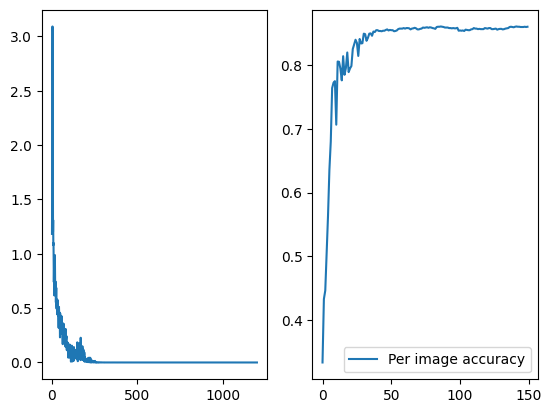

In [12]:
#@title training loop

EPOCHS = 150

LossList, ImgAccList = [], []
model = MyModel().to('cuda')

optimizer = torch.optim.Adam(model.parameters())
loss_objective = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):

    model.train()
    for x_tr, y_tr in training_generator:

        optimizer.zero_grad()

        out, _ = model(x_tr)
        loss = loss_objective(out, y_tr.flatten())

        loss.backward()
        LossList.append(loss.item())

        optimizer.step()

    with torch.no_grad():
        model.eval()
        ImgAcc = model.evaluate(test_generator)
        ImgAccList.append(ImgAcc)

    if epoch % 5 == 0 and epoch != 0: clear_output()

    print(
    f'Epoch {epoch+1}, \n ',
    f'Loss: {LossList[-1]}, \n ',
    f'Img Accuracy: {ImgAccList[-1]}, \n ',
    "--"*25
    )


plt.figure(1)
plt.subplot(121)
plt.plot(LossList)
plt.subplot(122)
plt.plot(ImgAccList, label='Per image accuracy')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix

model.eval()

preds = []
labels = []

with torch.no_grad():
    for x, y in test_generator:
        labels.append(y)
        out, _ = model(x)
        preds.append(out.argmax(1))
        break


labels = torch.concatenate(labels)
preds = torch.concatenate(preds)

matrix = confusion_matrix(labels.numpy(force=True), preds.numpy(force=True))
print(matrix.diagonal()/matrix.sum(axis=1))


[0.85714286 0.82191781 0.87719298]


In [14]:
unseen_class_data = np.load('/content/drive/MyDrive/DeepLearningCourse/data/new_evaluation_data_with_labels.npz')
unseen_class_data_unlabeled_images = np.load('/content/drive/MyDrive/DeepLearningCourse/data/new_evaluation_data_without_labels.npz')
unseen_class_data_unlabeled_labels = np.load('/content/drive/MyDrive/DeepLearningCourse/data/labels_for_new_evaluation_data_without_labels.npz')

unseen_class_dataset = MyDataset(unseen_class_data['a'], unseen_class_data['b'])
unseen_class_dataset_unlabeled = MyDataset(unseen_class_data_unlabeled_images['a'], unseen_class_data_unlabeled_labels['a'])

batch_size = 750

unseen_class_generator = DataLoader(unseen_class_dataset,
                                batch_size=batch_size,
                                shuffle=False)


In [15]:
model.train()

preds = []
labels = []

with torch.no_grad():
    for x, y in unseen_class_generator:
        labels.append(y)
        break

    for _ in range(10):
        out, _ = model(x)
        preds.append(torch.nn.functional.softmax(out, dim=1)[None, :, :])

labels = torch.concatenate(labels)
preds = torch.concatenate(preds)

In [16]:
mean_preds = torch.mean(preds, dim=0)
uncertainty = torch.sum(-mean_preds*torch.log(mean_preds), 1)

In [17]:

unkown_class_label = torch.unique(labels).max().item()
print(unkown_class_label)

known_classes = torch.where(labels != unkown_class_label)[0]
unknown_class = torch.where(labels == unkown_class_label)[0]

3


In [18]:
print(torch.mean(uncertainty[known_classes]))
print(torch.mean(uncertainty[unknown_class]))

tensor(0.0725, device='cuda:0')
tensor(0.2358, device='cuda:0')


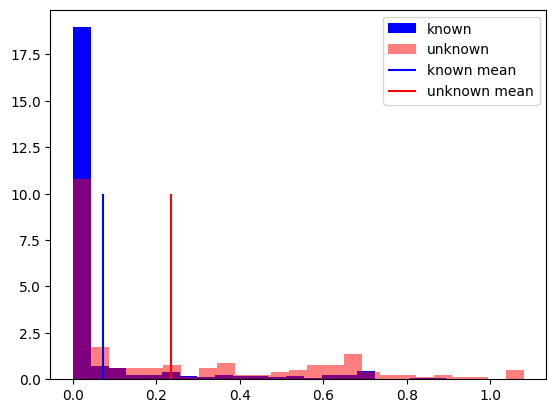

In [19]:
plt.figure(1)
plt.hist(uncertainty[known_classes].numpy(force=True), label='known', stacked=True, density=True, bins=25, color='blue')
plt.hist(uncertainty[unknown_class].numpy(force=True), label='unknown', stacked=True, density=True, bins=25, alpha=0.5, color='red')
plt.vlines(torch.mean(uncertainty[known_classes]).item(), 0, 10, label='known mean', color='blue')
plt.vlines(torch.mean(uncertainty[unknown_class]).item(), 0, 10, label='unknown mean', color='red')
plt.legend()
plt.show()

In [ ]:
ood_detection = uncertainty > 0.05
ood_labels = (labels == 3)

print(torch.unique(labels, return_counts=True))
print(torch.sum(ood_detection * ood_labels))


(tensor([0, 1, 2, 3], device='cuda:0'), tensor([185, 192, 189, 184], device='cuda:0'))
tensor(95, device='cuda:0')
